# Test

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
from learn import *
sys.path.insert(0, 'code')
from v17 import *
from v17 import _internal_validate_predict_best_param

In [3]:
sz = 256
num_slice = 9

num_gpus = 2
gpu_start = 4
num_workers = 8
device_ids = range(gpu_start, gpu_start + num_gpus)
# device_ids = [0,1,4,5]
torch.cuda.set_device(gpu_start)
bs = 8

model_name = 'deeplab'
datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
datapath = datapaths[1]

## Preprocessing

In [4]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}

In [5]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[3]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[1]}
# !python code/v5_im-full_rgb.py preproc_test {datapaths[2]}

## evalfscore

In [7]:
model_name = 'deeplab'
data = None
is_eval, is_pred = True, False

In [8]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-paris')


Data finished loading: data/train/AOI_3_Paris_Train


In [9]:
%%time
preds = learn.predict().squeeze()

CPU times: user 50min 17s, sys: 4min 1s, total: 54min 18s
Wall time: 1min 33s


In [10]:
%%time
evalfscore(datapath, preds)

CPU times: user 2min 41s, sys: 11 s, total: 2min 52s
Wall time: 1min 47s


(0.693127, 0.502204)

In [ ]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]
print(preds.shape)

In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=600,
                          scores=scores, is_best=0, thresh=0.5)

In [ ]:
with open(FMT_VALTESTPOLY_PATH.format('AOI_3_Paris')) as f:
    polys = f.readlines()
len([o for o in polys if 'EMPTY' not in o])

Plot images

In [ ]:
fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix='AOI_3_Paris')
df_train = pd.read_csv(fn_train)

In [ ]:
df_train[df_train.ImageId == 'AOI_3_Paris_img485']

In [ ]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds>0.5])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])
x_big[0].shape

In [ ]:
t = np.unique(preds_big[89]); t

In [ ]:
np.sum(preds_big[89] == 0)

In [ ]:
idx = 89
data_im = zip(preds_big[idx:idx + 9], x_big[idx:idx + 9], y_big[idx:idx + 9])
plot_ims(data_im, figsize=4)

In [ ]:
idx = 25
tx = denorm(x[idx * 9:idx * 9 + 16])
data_im = zip(tx[np.arange(0, 9, 3)],tx[np.arange(1, 9, 3)], tx[np.arange(2, 9, 3)])
plot_ims(data_im, figsize=3)

In [ ]:
fn_out = FMT_VALTESTTRUTH_PATH.format('AOI_3_Paris')
with open(fn_out, 'r') as f:
    t = f.readlines()
[o for o in t if 'AOI_3_Paris_img100,' in o]

## testproc

In [ ]:
data = None
is_eval, is_pred = False, True

In [ ]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-paris')

In [ ]:
%%time
preds = learn.predict().squeeze()

In [ ]:
testproc(datapath, preds)

### Eyeballing test result

In [44]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]
print(preds.shape)

(3105, 256, 256)
CPU times: user 38.3 s, sys: 10.8 s, total: 49.2 s
Wall time: 7.76 s


In [45]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])

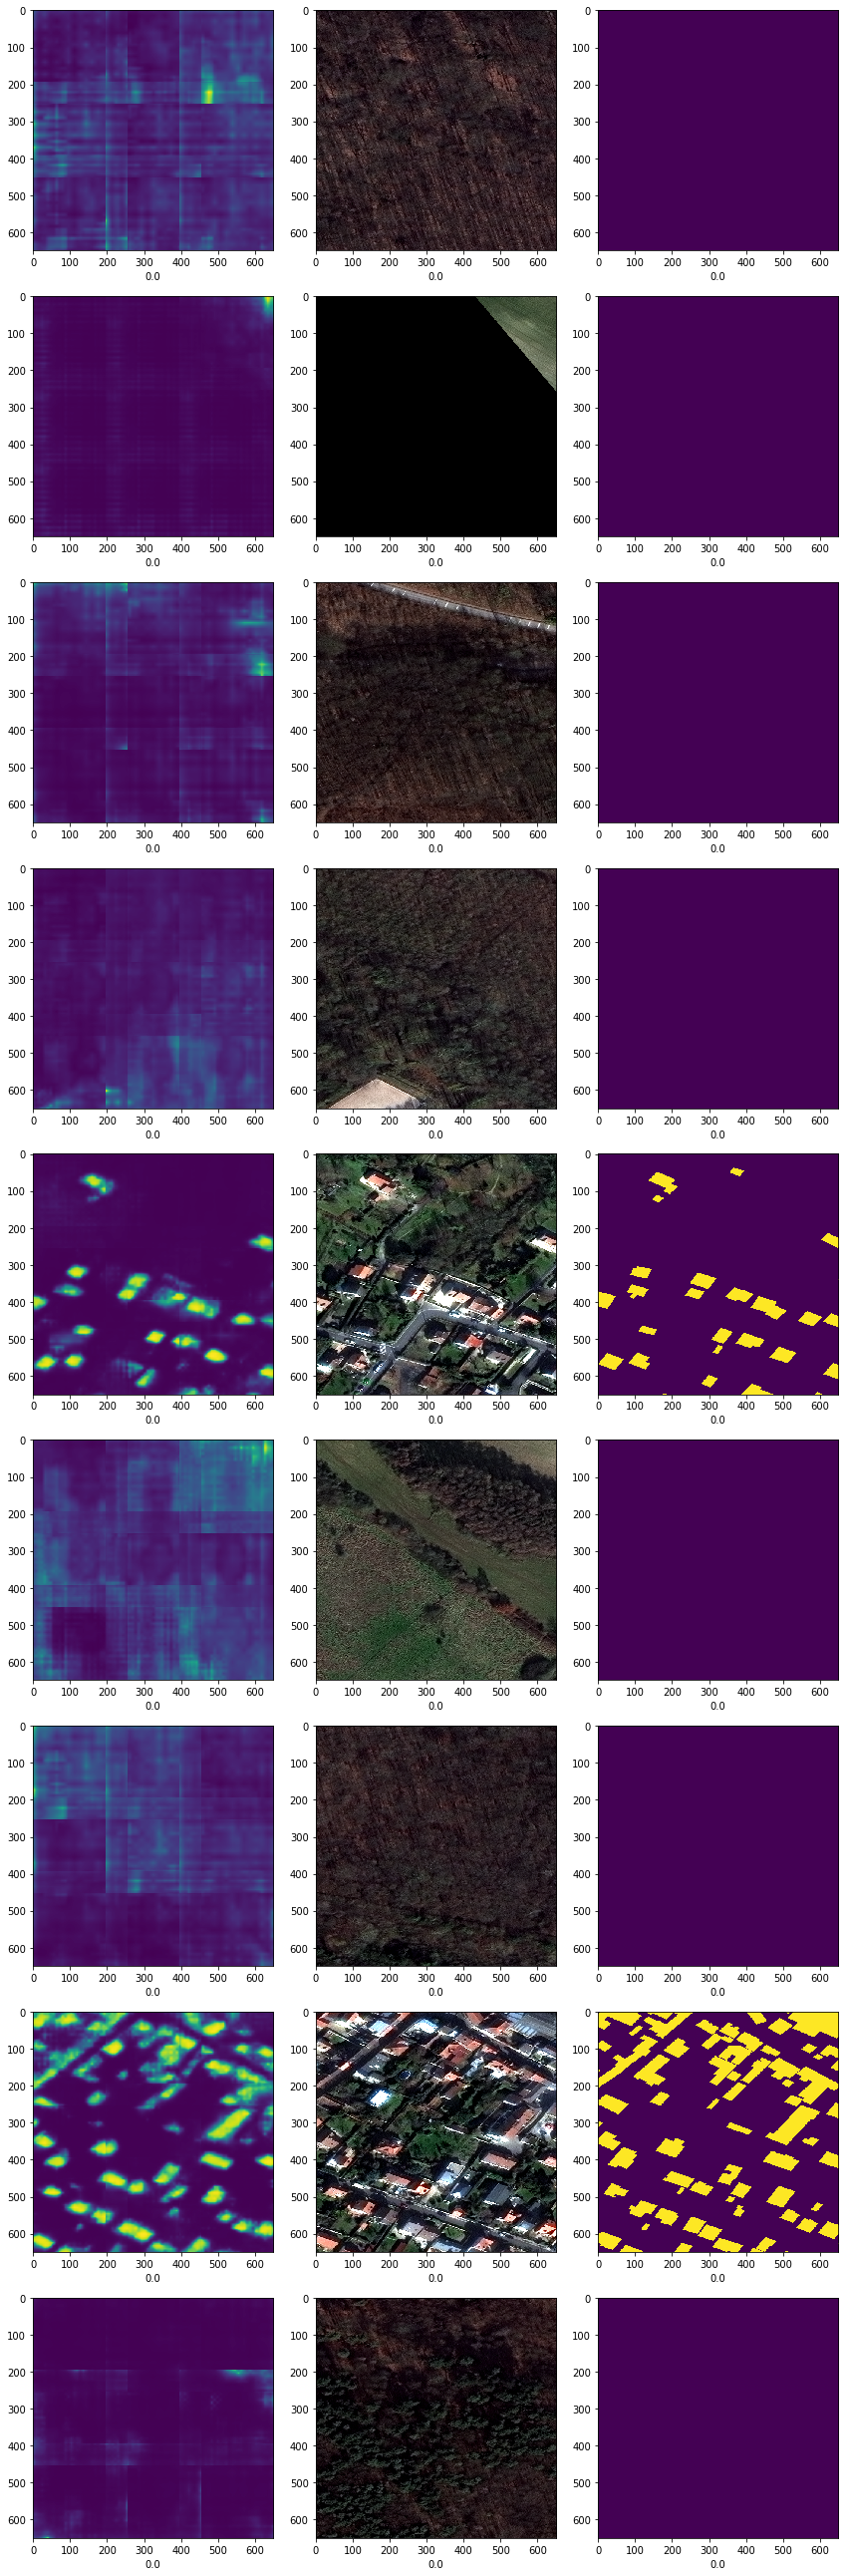

In [51]:
idx = 0
num_ims = 9
data_im = zip(preds_big[idx:idx + num_ims], x_big[idx:idx + num_ims], y_big[idx:idx + num_ims])
plot_ims(data_im, figsize=4)

In [ ]:
scores = None

In [ ]:
scores = plot_worse_preds(x_big, y_big, preds_big, fscore, scores=scores, shift=100)

## Pixel level best threshold

In [46]:
fscore(preds_big, y_big, thresh=0.25)

0.7759074510092517

In [ ]:
# wrong pytorch implementation
%%time
threshs = np.linspace(0, 1, 3)
t_preds_big, t_y_big = T(preds_big).float(), T(y_big).float()
with ThreadPoolExecutor(max_workers=8) as e:
    gen = e.map(partial(pr, t_preds_big, t_y_big), threshs)

In [ ]:
%%time
threshs = np.linspace(0, 1, 20)
score = [pr_np(preds_big, y_big, thresh) for thresh in threshs]

In [ ]:
score

In [ ]:
res = [(o[0][0], o[1][0]) for o in gen]

In [ ]:
plt.plot(*zip(*score))

In [ ]:
distance = [o[0] - o[1] for o in score]

In [ ]:
np.argmin(np.abs(distance)) / 20 

## Polygon best threshold

In [71]:
def evalfscore_thresh(thresh):
    return evalfscore(datapath, preds, thresh=thresh)

In [67]:
# %%time
# threshs = np.linspace(0, 1, 20)
# polygon_pr = []
# for thresh in threshs:
#     polygon_pr.append(evalfscore(datapath, preds, thresh))
# plt.plot(polygon_pr)

0.0 (0, 0)
0.05263157894736842 (0.281055, 0.169017)


KeyboardInterrupt: 

In [ ]:
%%time
threshs = np.linspace(0, 1, 21)
for thresh in threshs:
    with ThreadPoolExecutor(max_workers=8) as e:
        polygon_pr = list(e.map(evalfscore_thresh(thresh)))
plt.plot(polygon_pr)

In [66]:
plt.plot(*zip(*polygon_pr))

[(0, 0)]

## Guided Filter

In [ ]:
sns.set(style="white")
srcs = (preds_big * 255).astype('uint8')
guides = (x_big * 255).astype('uint8')
gts = (y_big * 255).astype('uint8')

In [ ]:
idx = 16
plt.imshow(cv2.ximgproc.guidedFilter(guides[16], srcs[16], radius=radius[3], eps=eps[3]))

In [ ]:
%%time
rows, cols = 5, 10
radius = np.arange(1, 6, 1).astype('uint8')
eps = np.arange(10, 50, 40 / cols).astype('uint8')
res = np.empty([rows, cols] + list(srcs.shape))
for row, r in enumerate(radius):
    for col, e in enumerate(eps):    
#         for i, src in enumerate(srcs):
        with ThreadPoolExecutor(max_workers=8) as e:
            res_batch = list(e.map((partial(cv2.ximgproc.guidedFilter, radius=r, eps=e), guides, srcs)))
            for i, res_im in enumerate(res_batch):
                res[row, col, i] = res_im

In [ ]:
%%time
score_mat = np.empty([rows, cols])
for row, r in enumerate(radius):
    with ThreadPoolExecutor(max_workers=8) as e:
        res_cols = list(e.map(fscore, res[row] > int(255), np.broadcast_to(gts, [cols] + list(gts.shape))))
        for i, res_col in enumerate(res_cols):
            score_mat[row, i] = res_col

In [ ]:
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(score_mat, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})
# ax.xaxis.set_ticks(eps)
print(score_mat.argmax())